In [21]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

In [22]:
#importe un dataframe contenant les images en hsv (car c'etait le format que je pensais le meilleur precedement) et les labels
import pickle
filename = 'C:\\Users\\Eliaz\\Documents\\GitHub\\Animal-identification-NN\\dataset\\raw-img\\datasetHSV.pkl'
df = pickle.load(open(filename, 'rb'))

In [23]:
working_df = df.copy()
del df
#working_df = working_df[np.isin(working_df['label'], ['cat', 'dog'])]
print(working_df['label'].value_counts())

dog          4863
spider       4821
chicken      3098
horse        2623
butterfly    2112
cow          1866
squirrel     1862
sheep        1820
cat          1668
elephant     1446
Name: label, dtype: int64


In [24]:
print(working_df.columns)

Index(['label', 'img_hsv'], dtype='object')


In [25]:
#resize
size=80
working_df['img_hsv'] = working_df['img_hsv'].apply(lambda x: cv2.resize(x, (size, size)))
print(working_df['img_hsv'].apply(lambda x: x.shape).unique().shape)

(1,)


In [26]:
#hsv to gray
working_df['img_hsv'] = working_df['img_hsv'].apply(lambda x: cv2.cvtColor(x, cv2.COLOR_HSV2RGB))
#working_df['img_hsv'] = working_df['img_hsv'].apply(lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2GRAY))

In [27]:
#img to array
print(working_df['img_hsv'].shape)
print(working_df['img_hsv'].iloc[0].shape)
print(type(working_df['img_hsv']))
print(type(working_df['img_hsv'].iloc[0]))
working_df['img_hsv'] = working_df['img_hsv'].apply(lambda x: x.reshape(size, size, 3))
#working_df['img_hsv'] = working_df['img_hsv'].apply(lambda x: x.reshape(size, size, 1))
X = working_df['img_hsv'].values
X = np.stack(X)
print(X.shape)

(26179,)
(80, 80, 3)
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
(26179, 80, 80, 3)


In [28]:
#transforme le texte des labels en chiffres
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
working_df['label'] = le.fit_transform(working_df['label']) # 0 cat, 1 dog
print(working_df['label'].value_counts())

4    4863
8    4821
2    3098
6    2623
0    2112
3    1866
9    1862
7    1820
1    1668
5    1446
Name: label, dtype: int64


In [29]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, working_df['label'], test_size=0.2)


In [30]:
from tensorflow.keras.utils import to_categorical
num = 2
train_Y_one_hot = to_categorical(y_train)
test_Y_one_hot = to_categorical(y_test)
print('turns',y_train.iloc[num],'into', train_Y_one_hot[num])

turns 4 into [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [31]:
#impression image 
# img = X[num]
# rgb = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
# plt.imshow(rgb)

In [32]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU

In [33]:
num_classes = train_Y_one_hot.shape[1]
print(num_classes)

10


In [34]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5),activation='linear',input_shape=(size,size,X.shape[3])))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
#reseau de neurone "classique" pour la deriere couche cachee
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
#couche de sortie
model.add(Dense(num_classes, activation='softmax'))

In [35]:
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy, optimizer=tensorflow.keras.optimizers.Adam(),metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 76, 76, 32)        2432      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 76, 76, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 36, 36, 64)        18496     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 36, 36, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                  

In [37]:
model.fit(X_train, train_Y_one_hot, batch_size=128, epochs=10, verbose=1, validation_data=(X_test, test_Y_one_hot))

Epoch 1/10
164/164 [==============================] - 113s 683ms/step - loss: 26.7026 - accuracy: 0.2253 - val_loss: 2.2295 - val_accuracy: 0.2878
Epoch 2/10
164/164 [==============================] - 117s 713ms/step - loss: 2.0553 - accuracy: 0.3422 - val_loss: 2.1307 - val_accuracy: 0.3394
Epoch 3/10
164/164 [==============================] - 113s 689ms/step - loss: 1.6959 - accuracy: 0.4344 - val_loss: 1.7368 - val_accuracy: 0.4328
Epoch 4/10
 54/164 [========>.....................] - ETA: 1:12 - loss: 1.4509 - accuracy: 0.5135

KeyboardInterrupt: 

Text(0.5, 0, 'epoch')

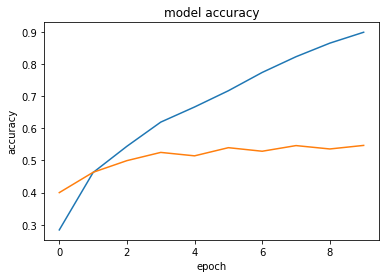

In [ ]:
#graph accuracy vs val_accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

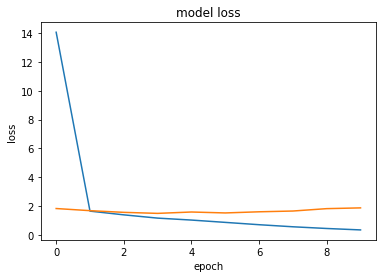

In [ ]:
#graph loss vs val_loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [ ]:
eval = model.evaluate(X_test, test_Y_one_hot, verbose=1)

164/164 [==============================] - 8s 51ms/step - loss: 1.8632 - accuracy: 0.5468
